#### Case Study Tutorial of using Pybaseball for MLB Data Analysis, specifically predicting war of pitchers

In [8]:
import os
import pandas as pd
import numpy as np 
from pybaseball import pitching_stats
from pybaseball import cache
cache.enable()

Prediction of Pitchers WAR

In [9]:
START = 2005
END = 2024

pitching = pitching_stats(start_season=START, end_season=END)

pitching.to_csv('pitching.csv', index=False)
pitching = pd.read_csv('pitching.csv')
pitching = pitching.groupby("IDfg", group_keys=False).filter(lambda x: x.shape[0] > 1)

Getting WAR from Pitcher 

In [10]:
def next_season(player):
    player = player.sort_values(by='Season')
    player["Next_WAR"] = player["WAR"].shift(-1)
    return player

pitching = pitching.groupby("IDfg", group_keys=False).apply(next_season)

/var/folders/96/539zp3p17_dcx5q784pttdk00000gn/T/ipykernel_4122/3248699385.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pitching = pitching.groupby("IDfg", group_keys=False).apply(next_season)


Preprocess data by removing NA values

In [11]:
null_count = pitching.isnull().sum()

complete_cols = list(pitching.columns[null_count == 0])
pitching = pitching[complete_cols + ["Next_WAR"]].copy()


print(pitching.dtypes[pitching.dtypes == "object"])
pitching.drop(columns=["Dollars", "Age Rng", "Team"], inplace=True)

pitching_full = pitching.copy()
pitching = pitching.dropna()


Name       object
Team       object
Dollars    object
Age Rng    object
dtype: object


In [12]:
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import TimeSeriesSplit


rr = Ridge(alpha=0.1)
split = TimeSeriesSplit(n_splits=3)

sfs = SequentialFeatureSelector(rr, 
                                n_features_to_select=20, 
                                direction='forward', 
                                cv=split,
                                n_jobs=4)


removed_columns = ["Name_WAR", "Name", "IDfg", "Season"]
selected_columns = pitching.columns[~pitching.columns.isin(removed_columns)]



In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
pitching.loc[:, selected_columns] = scaler.fit_transform(pitching[selected_columns])

sfs.fit(pitching[selected_columns], pitching["Next_WAR"])


/var/folders/96/539zp3p17_dcx5q784pttdk00000gn/T/ipykernel_4122/2518841098.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.48 0.4  0.44 0.48 0.6  0.84 0.88 0.76 0.8  0.76 0.8  0.84 0.24 0.28
 0.32 0.36 0.4  0.44 0.48 0.52 0.56 0.72 0.76 0.28 0.36 0.4  0.48 0.52
 0.56 0.6  0.64 0.68 0.72 0.8  0.24 0.28 0.32 0.36 0.4  0.44 0.48 0.52
 0.56 0.6  0.2  0.24 0.28 0.32 0.36 0.6  0.16 0.2  0.24 0.28 0.48 0.72
 0.8  0.84 0.88 0.16 0.2  0.24 0.28 0.32 0.36 0.4  0.44 0.48 0.56 0.28
 0.32 0.48 0.52 0.44 0.32 0.2  0.24 0.28 0.32 0.36 0.44 0.32 0.4  0.44
 0.48 0.52 0.56 0.6  0.64 0.68 0.44 0.48 0.52 0.56 0.6  0.48 0.52 0.28
 0.32 0.36 0.44 0.28 0.32 0.36 0.4  0.44 0.56 0.6  0.64 0.4  0.44 0.48
 0.24 0.32 0.36 0.48 0.52 0.56 0.48 0.24 0.28 0.32 0.36 0.4  0.32 0.52
 0.56 0.32 0.36 0.4  0.44 0.48 0.4  0.44 0.48 0.52 0.56 0.64 0.68 0.52
 0.56 0.6  0.64 0.68 0.36 0.4  0.44 0.56 0.6  0.64 0.52 0.28 0.32 0.36
 0.4  0.44 0.48 0.16

SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                          estimator=Ridge(alpha=0.1), n_features_to_select=20,
                          n_jobs=4)

In [14]:
predictors = list(selected_columns[sfs.get_support()])
print(predictors)

['HBP', 'WP', 'Balls', 'BU', 'BUH', 'HR/FB', 'BUH%', 'inLI', 'gmLI', 'FB% 2', 'BIP-Wins', 'LOB-Wins', 'FDP-Wins', 'Pull%', 'Soft%', 'BABIP+', 'HR/FB%+', 'Cent%+', 'Med%+', 'Next_WAR']


Train the model on prior seasons




In [15]:
# predict the next season's WAR, collect the data, and save it

def predict(data, model, predictors, start=9, step=1):
    all_predictions = []
    years = sorted(data["Season"].unique())

    for i in range(start, len(years), step):
        current_year = years[i]

        train = data[data["Season"] < current_year]
        test = data[data["Season"] == current_year]

        model.fit(train[predictors], train["Next_WAR"])
        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index=test.index)
        combined = pd.concat([test[["Season", "Next_WAR"]], 
                              preds.rename("predictions")], axis=1)
        combined["actual"] = combined["Next_WAR"]
        combined = combined.drop("Next_WAR", axis=1)

        all_predictions.append(combined)

    return pd.concat(all_predictions).reset_index(drop=True)

predictions = predict(pitching, rr, predictors)
predictions = predictions.rename(columns={"predictions": "Predicted_WAR"})

print(predictions.head())




   Season  Predicted_WAR    actual
0    2014       0.340302  0.339623
1    2014       0.386818  0.386792
2    2014       0.396094  0.396226
3    2014       0.321093  0.320755
4    2014       0.396093  0.396226


RMSE: 0.00


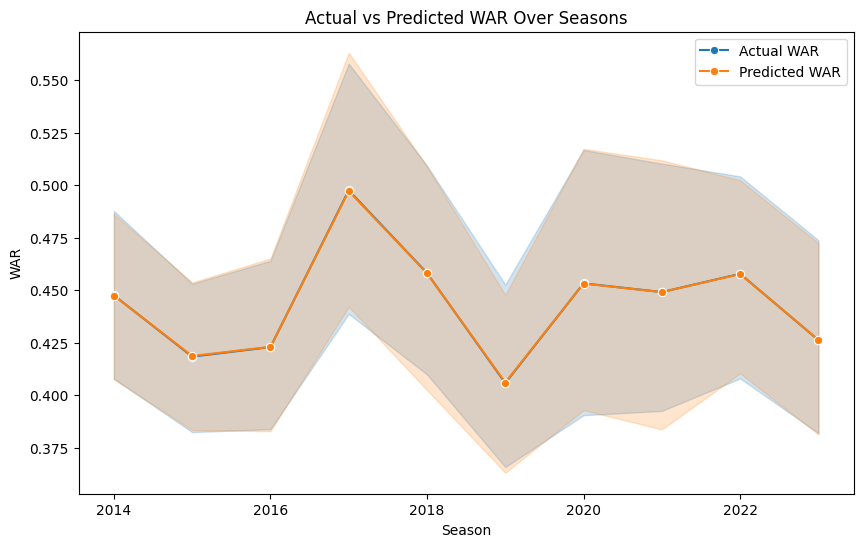

In [23]:
pitching = pitching[pitching['Season'] != 2020]


from sklearn.metrics import mean_squared_error

mse = mean_squared_error(predictions["actual"], predictions["Predicted_WAR"])
rmse = mse ** 0.5
print(f"RMSE: {rmse:.2f}")


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.lineplot(x='Season', y='actual', data=predictions, label='Actual WAR', marker='o')
sns.lineplot(x='Season', y='Predicted_WAR', data=predictions, label='Predicted WAR', marker='o')
plt.title('Actual vs Predicted WAR Over Seasons')
plt.xlabel('Season')
plt.ylabel('WAR')
plt.legend()
plt.show()

